In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [2]:
# 데이터 불러오기
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# 각종 그림 그리기

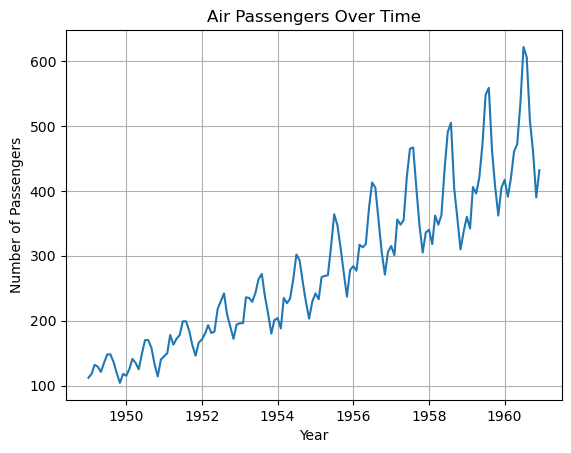

In [3]:
#  datetime 형태로 변환 
data['Month'] = pd.to_datetime(data['Month'])

# Plotting
plt.plot(data['Month'], data['#Passengers'])
plt.title('Air Passengers Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()



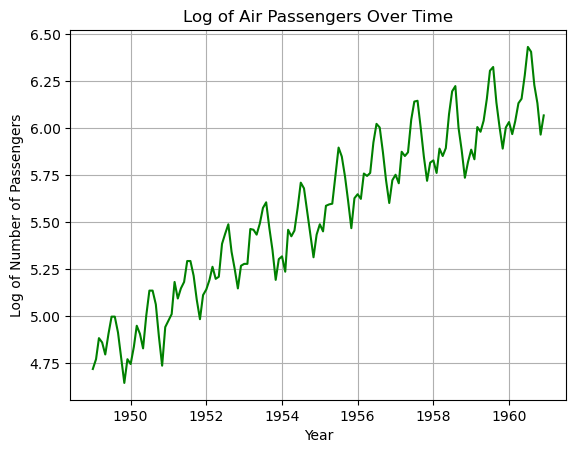

In [4]:
# 변량이 증가하는 경향이 나타나므로 log 변환
data['Log_Passengers'] = np.log(data['#Passengers'])
plt.plot(data['Month'], data['Log_Passengers'], color='green')
plt.title('Log of Air Passengers Over Time')
plt.xlabel('Year')
plt.ylabel('Log of Number of Passengers')
plt.grid(True)
plt.show()

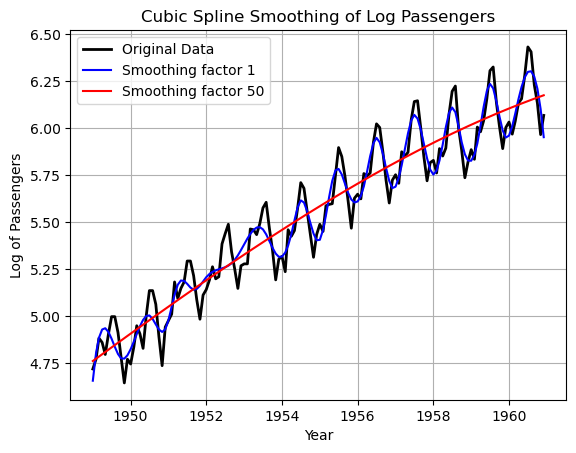

In [5]:
colors = ['blue', 'red']
smoothing_factors = [1, 50]

# 원 데이터 그리고
plt.plot(data['Month'], data['Log_Passengers'], label='Original Data', color='black', linewidth=2)

# 각 smoothing_factor로 smoothing 해서 그리기 
for s, color in zip(smoothing_factors, colors):
    spline = UnivariateSpline(data['Month'].map(pd.Timestamp.toordinal), data['Log_Passengers'].fillna(0), s=s)
    plt.plot(data['Month'], spline(data['Month'].map(pd.Timestamp.toordinal)), label=f'Smoothing factor {s}', color=color)

plt.xlabel('Year')
plt.ylabel('Log of Passengers')
plt.title('Cubic Spline Smoothing of Log Passengers')
plt.legend()
plt.grid(True)
plt.show()


# 정상성 확인을 위한 Augmented Dickey-Fuller test 

In [6]:
adf_test = adfuller(data['Log_Passengers'].dropna())

adf_results = pd.DataFrame({
    'ADF Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Number of Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Value (1%)': adf_test[4]['1%'],
    'Critical Value (5%)': adf_test[4]['5%'],
    'Critical Value (10%)': adf_test[4]['10%']
}, index=['Value']).transpose()

adf_results

,Value
ADF Test Statistic,-1.717017
p-value,0.422367
Number of Lags Used,13.000000
Number of Observations Used,130.000000
Critical Value (1%),-3.481682
Critical Value (5%),-2.884042
Critical Value (10%),-2.578770


# deterministic model

In [7]:
# 시간 인덱스 생성
data['TimeIndex'] = range(1, len(data) + 1)
# 월은 나타내기 위한 11개의 더미 변수 생성
data['Month_Num'] = data['Month'].dt.month
month_dummies = pd.get_dummies(data['Month_Num'], prefix='Month', drop_first=True)

# D회귀 모형을 위한 변수 생성
X_new = pd.concat([data[['TimeIndex']], month_dummies], axis=1)
X_new = sm.add_constant(X_new)  # adding a constant
y = data['Log_Passengers']

# 회귀 분석 무형 모형 구축
model_new = sm.OLS(y, X_new).fit()

# 모형 설명
model_summary_new = model_new.summary()
model_summary_new

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Log_Passengers   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     649.4
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          2.31e-110
Time:                        16:27:17   Log-Likelihood:                 209.30
No. Observations:                 144   AIC:                            -392.6
Df Residuals:                     131   BIC:                            -354.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7268      0.019    250.180      0.000       4.689       4.764
TimeIndex      0.0101      0.000     84.399      0.000       0.010       0.010
Month_2       -0.0221      0.024     -0.911      0.364      -0.070       0.026
Month_3        0.1082      0.024      4.468      0.000       0.060       0.156
Month_4        0.0769      0.024      3.176      0.002       0.029       0.125
Month_5        0.0745      0.024      3.078      0.003       0.027       0.122
Month_6        0.1967      0.024      8.121      0.000       0.149       0.245
Month_7        0.3006      0.024     12.411      0.000       0.253       0.349
Month_8        0.2913      0.024     12.026      0.000       0.243       0.339
Month_9        0.1467      0.024      6.054      0.000       0.099       0.195
Month_10       0.0085      0.024      0.352      0.725      -0.039       0.056
Month_11      -0.1352      0.024     -5.577      0.000      -0.183      -0.087
Month_12      -0.0213      0.024     -0.879      0.381      -0.069       0.027
==============================================================================
Omnibus:                        2.692   Durbin-Watson:                   0.425
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.412
Skew:                          -0.224   Prob(JB):                        0.299
Kurtosis:                       2.551   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

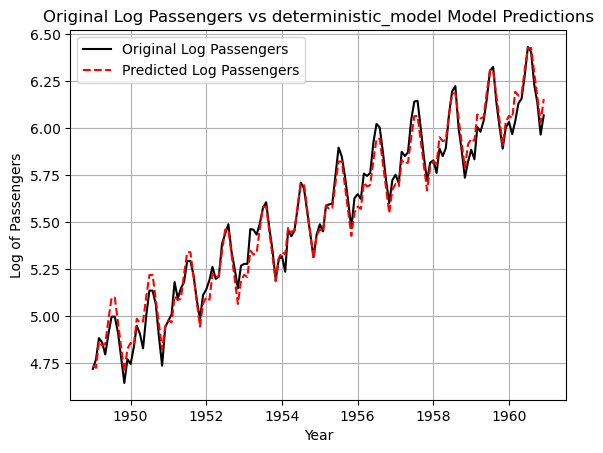

,lb_stat,lb_pvalue
10,354.765873,3.880198e-70


In [8]:
# 예측값 생성
data['deterministic_model'] = model_new.predict(X_new)

# 원데이터와 비교 그림
plt.plot(data['Month'], data['Log_Passengers'], label='Original Log Passengers', color='black')
plt.plot(data['Month'], data['deterministic_model'], label='Predicted Log Passengers', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Log of Passengers')
plt.title('Original Log Passengers vs deterministic_model Model Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Ljung-Box 테스트
residuals = model_new.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_test

# acf, pacf

C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


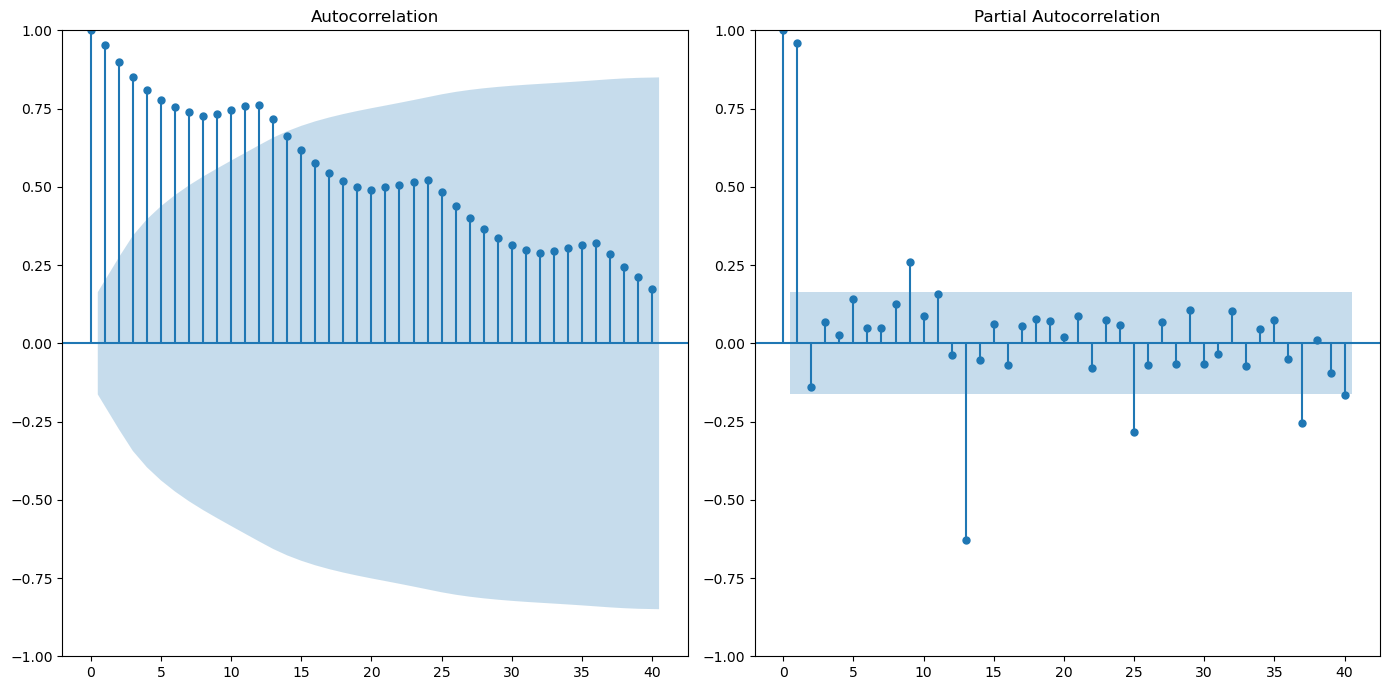

In [9]:
# acf, pacf 그리기
plt.figure(figsize=(14, 7))
plot_acf(data['Log_Passengers'], lags=40, ax=plt.subplot(1, 2, 1))
plot_pacf(data['Log_Passengers'], lags=40, ax=plt.subplot(1, 2, 2))

plt.tight_layout()
plt.show()


# stachastic model AR(1)

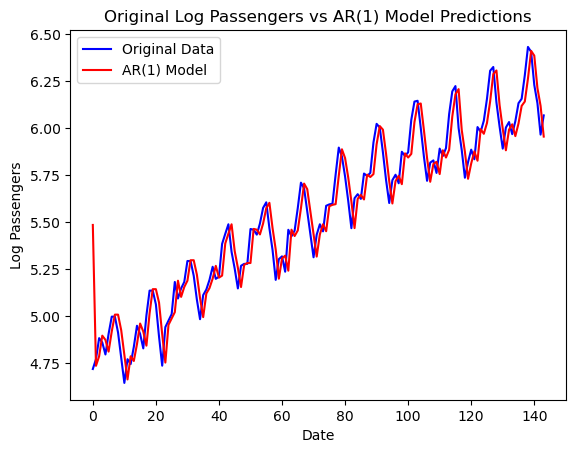

(      lb_stat  lb_pvalue
 10  20.197925   0.027435,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:         Log_Passengers   No. Observations:                  144
 Model:                 ARIMA(1, 0, 0)   Log Likelihood                 117.065
 Date:                Thu, 09 Nov 2023   AIC                           -228.131
 Time:                        16:27:18   BIC                           -219.221
 Sample:                             0   HQIC                          -224.511
                                 - 144                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          5.4853      0.270     20.348      0.000       4.957       6.014
 ar.L1          0

In [10]:
# AR(1) 구축
model_ar1 = ARIMA(data['Log_Passengers'], order=(1, 0, 0))
results_ar1 = model_ar1.fit()

# Ljung-Box test
ljung_box_results = acorr_ljungbox(results_ar1.resid, lags=[10], return_df=True)

# 원데이터와 그림으로 비교
plt.plot(data['Log_Passengers'], label='Original Data', color='blue')
plt.plot(results_ar1.fittedvalues, label='AR(1) Model', color='red')
plt.title('Original Log Passengers vs AR(1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Log Passengers')
plt.legend()
plt.show()

ljung_box_results, results_ar1.summary()

# 1개월 차분 후 반복

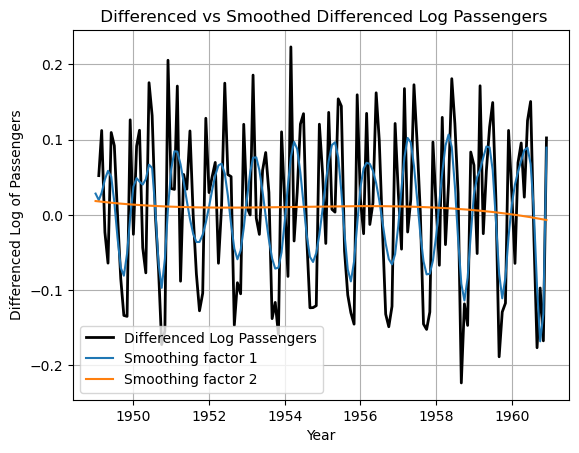

Augmented Dickey-Fuller test
                                  Value
ADF Test Statistic            -2.717131
p-value                        0.071121
Number of Lags Used           14.000000
Number of Observations Used  128.000000
Critical Value (1%)           -3.482501
Critical Value (5%)           -2.884398
Critical Value (10%)          -2.578960


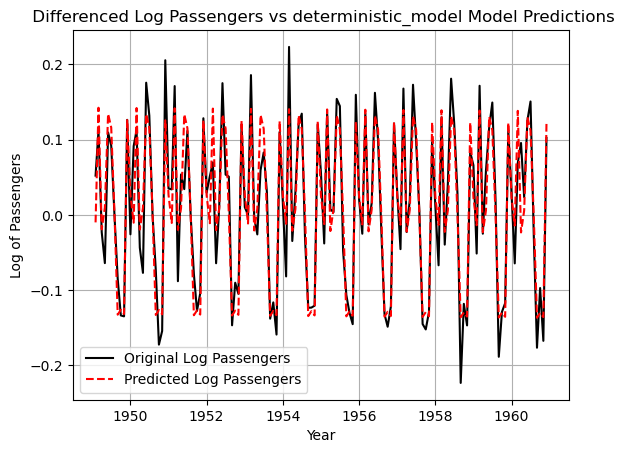

Ljung-Box test
      lb_stat  lb_pvalue
10  19.407658    0.03538


C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


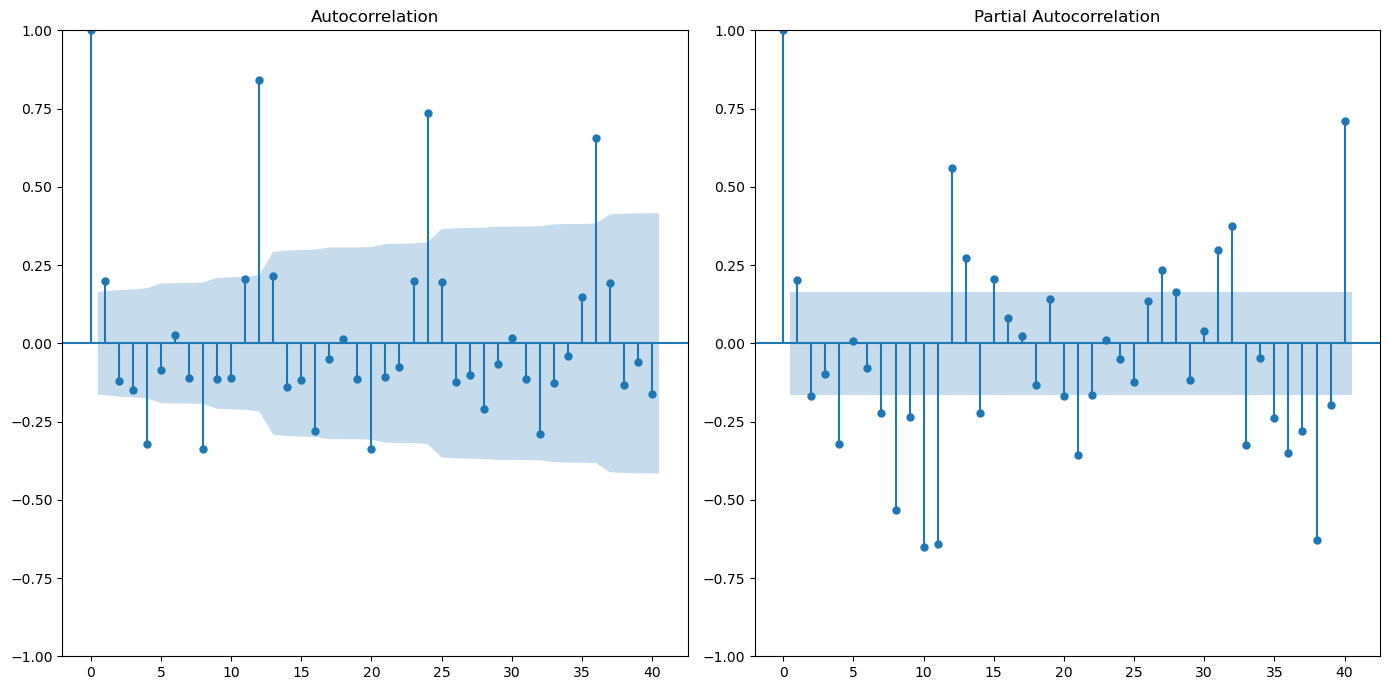

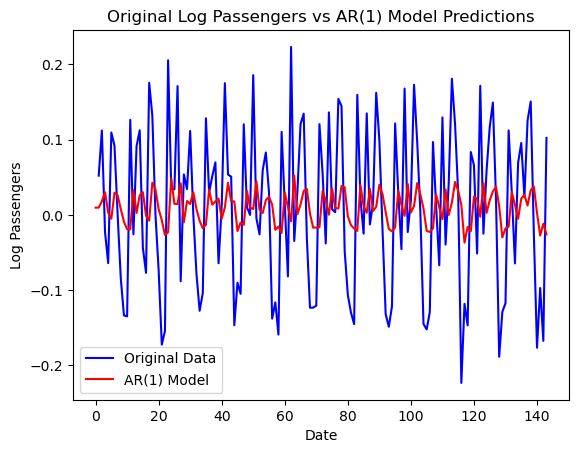

(      lb_stat  lb_pvalue
 10  37.423622   0.000048,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:     LogPassengers_diff   No. Observations:                  144
 Model:                 ARIMA(1, 0, 0)   Log Likelihood                 120.693
 Date:                Thu, 09 Nov 2023   AIC                           -235.386
 Time:                        16:27:19   BIC                           -226.476
 Sample:                             0   HQIC                          -231.766
                                 - 144                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.0097      0.012      0.794      0.427      -0.014       0.034
 ar.L1          0

In [11]:
# 차분
data['LogPassengers_diff'] = data['Log_Passengers'].diff().dropna()


# 차분 그림
smoothing_factors = [1, 2]

plt.plot(data['Month'], data['LogPassengers_diff'], label='Differenced Log Passengers', color='black', linewidth=2)
for s in smoothing_factors:
    spline = UnivariateSpline(data['Month'].map(pd.Timestamp.toordinal), data['LogPassengers_diff'].fillna(0), s=s)
    plt.plot(data['Month'], spline(data['Month'].map(pd.Timestamp.toordinal)), label=f'Smoothing factor {s}')

plt.xlabel('Year')
plt.ylabel('Differenced Log of Passengers')
plt.title(' Differenced vs Smoothed Differenced Log Passengers')
plt.legend()
plt.grid(True)
plt.show()

# 정상성 확인을 위한 Augmented Dickey-Fuller test 
print('Augmented Dickey-Fuller test' )
adf_test = adfuller(data['LogPassengers_diff'].dropna())

adf_results = pd.DataFrame({
    'ADF Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Number of Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Value (1%)': adf_test[4]['1%'],
    'Critical Value (5%)': adf_test[4]['5%'],
    'Critical Value (10%)': adf_test[4]['10%']
}, index=['Value']).transpose()

print(adf_results)

# deterministic model
data_diff = data.copy()
data_diff['DiffLogPassengers'] = data_diff['Log_Passengers'].diff()
data_diff = data_diff.dropna()

data_diff['TimeIndex'] = range(1, len(data_diff) + 1)
data_diff['Month_Num'] = data_diff['Month'].dt.month
month_dummies = pd.get_dummies(data_diff['Month_Num'], prefix='Month', drop_first=True)

X_new = pd.concat([data_diff[['TimeIndex']], month_dummies], axis=1)
X_new = sm.add_constant(X_new)  # adding a constant
y = data_diff['DiffLogPassengers']

model_new = sm.OLS(y, X_new).fit()

model_summary_new = model_new.summary()
model_summary_new

data_diff['deterministic_model'] = model_new.predict(X_new)

plt.plot(data_diff['Month'], data_diff['DiffLogPassengers'], label='Original Log Passengers', color='black')
plt.plot(data_diff['Month'], data_diff['deterministic_model'], label='Predicted Log Passengers', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Log of Passengers')
plt.title(' Differenced Log Passengers vs deterministic_model Model Predictions')
plt.legend()
plt.grid(True)
plt.show()

residuals = model_new.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print('Ljung-Box test')
print(lb_test)

# acf, pacf
plt.figure(figsize=(14, 7))
plot_acf(data['LogPassengers_diff'].dropna(), lags=40, ax=plt.subplot(1, 2, 1))
plot_pacf(data['LogPassengers_diff'].dropna(), lags=40, ax=plt.subplot(1, 2, 2))

plt.tight_layout()
plt.show()

# stachastic model AR(1)
model_ar1 = ARIMA(data['LogPassengers_diff'], order=(1, 0, 0))
results_ar1 = model_ar1.fit()

ljung_box_results = acorr_ljungbox(results_ar1.resid.dropna(), lags=[10], return_df=True)

plt.plot(data['LogPassengers_diff'], label='Original Data', color='blue')
plt.plot(results_ar1.fittedvalues, label='AR(1) Model', color='red')
plt.title('Original Log Passengers vs AR(1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Log Passengers')
plt.legend()
plt.show()

ljung_box_results, results_ar1.summary()


# 12개월 차분 후 반복

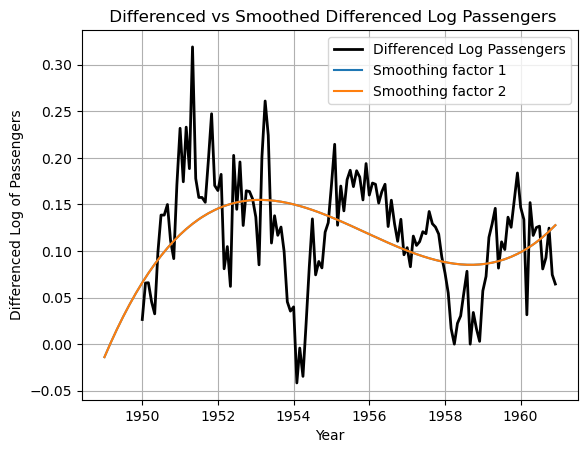

Augmented Dickey-Fuller test
                                  Value
ADF Test Statistic            -2.709577
p-value                        0.072396
Number of Lags Used           12.000000
Number of Observations Used  119.000000
Critical Value (1%)           -3.486535
Critical Value (5%)           -2.886151
Critical Value (10%)          -2.579896


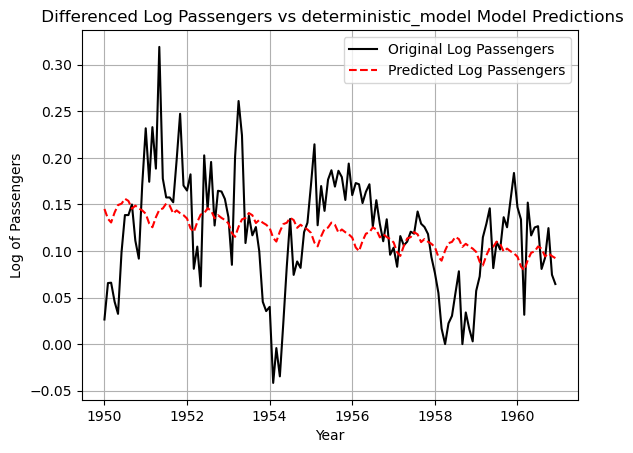

Ljung-Box test
       lb_stat     lb_pvalue
10  193.533056  3.594651e-36


C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


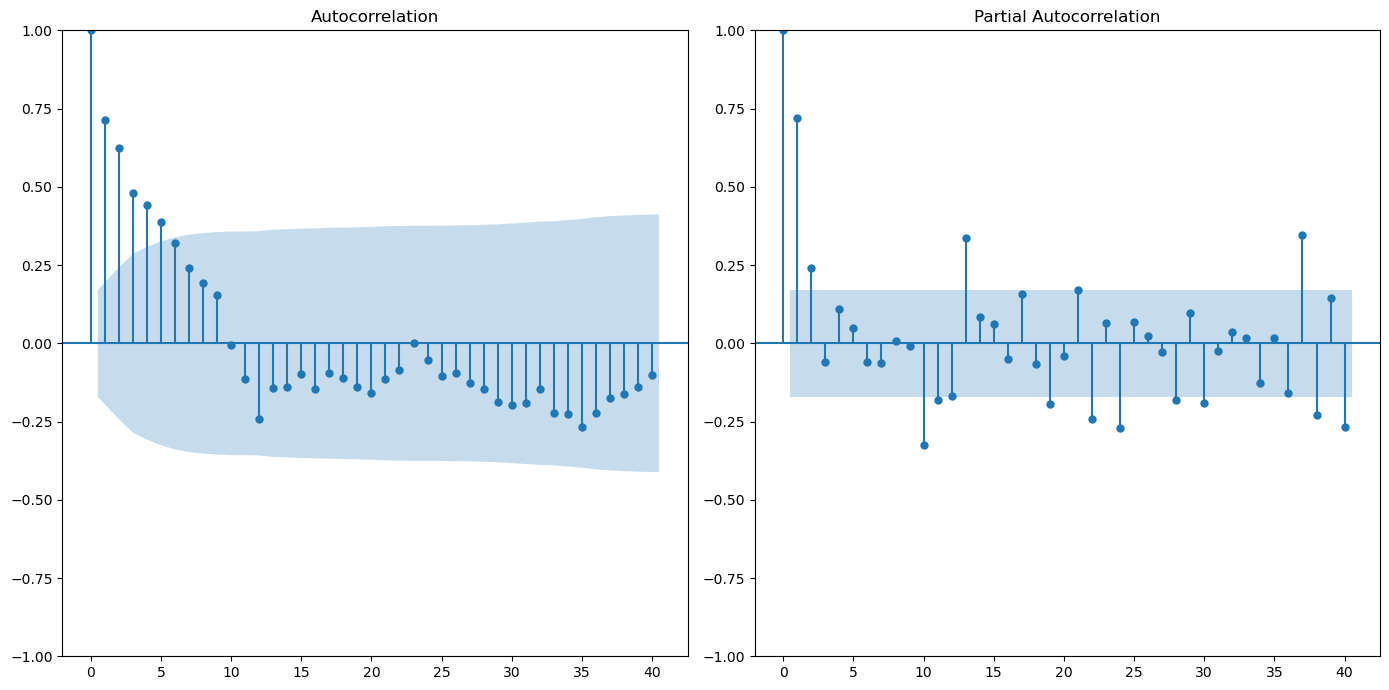

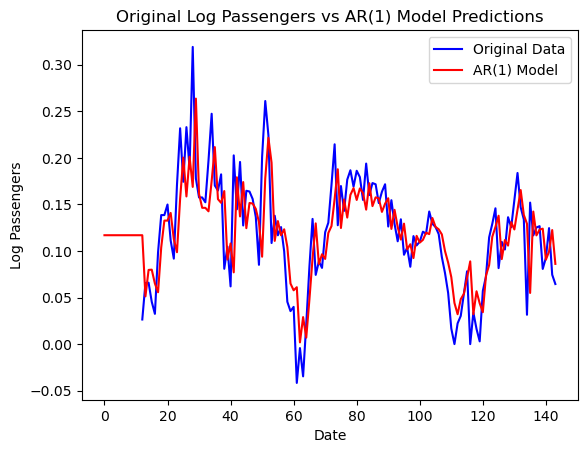

(      lb_stat  lb_pvalue
 10  17.890382   0.056841,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:     LogPassengers_diff   No. Observations:                  144
 Model:                 ARIMA(1, 0, 0)   Log Likelihood                 229.324
 Date:                Thu, 09 Nov 2023   AIC                           -452.647
 Time:                        16:27:19   BIC                           -443.738
 Sample:                             0   HQIC                          -449.027
                                 - 144                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.1170      0.013      8.788      0.000       0.091       0.143
 ar.L1          0

In [12]:
# 차분
data['LogPassengers_diff'] = data['Log_Passengers'].diff(12).dropna()


# 차분 그림
smoothing_factors = [1, 2]

plt.plot(data['Month'], data['LogPassengers_diff'], label='Differenced Log Passengers', color='black', linewidth=2)
for s in smoothing_factors:
    spline = UnivariateSpline(data['Month'].map(pd.Timestamp.toordinal), data['LogPassengers_diff'].fillna(0), s=s)
    plt.plot(data['Month'], spline(data['Month'].map(pd.Timestamp.toordinal)), label=f'Smoothing factor {s}')

plt.xlabel('Year')
plt.ylabel('Differenced Log of Passengers')
plt.title(' Differenced vs Smoothed Differenced Log Passengers')
plt.legend()
plt.grid(True)
plt.show()

# 정상성 확인을 위한 Augmented Dickey-Fuller test 
print('Augmented Dickey-Fuller test' )
adf_test = adfuller(data['LogPassengers_diff'].dropna())

adf_results = pd.DataFrame({
    'ADF Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Number of Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Value (1%)': adf_test[4]['1%'],
    'Critical Value (5%)': adf_test[4]['5%'],
    'Critical Value (10%)': adf_test[4]['10%']
}, index=['Value']).transpose()

print(adf_results)

# deterministic model
data_diff = data.copy()
data_diff['DiffLogPassengers'] = data_diff['Log_Passengers'].diff(12)
data_diff = data_diff.dropna()

data_diff['TimeIndex'] = range(1, len(data_diff) + 1)
data_diff['Month_Num'] = data_diff['Month'].dt.month
month_dummies = pd.get_dummies(data_diff['Month_Num'], prefix='Month', drop_first=True)

X_new = pd.concat([data_diff[['TimeIndex']], month_dummies], axis=1)
X_new = sm.add_constant(X_new)  # adding a constant
y = data_diff['DiffLogPassengers']

model_new = sm.OLS(y, X_new).fit()

model_summary_new = model_new.summary()
model_summary_new

data_diff['deterministic_model'] = model_new.predict(X_new)

plt.plot(data_diff['Month'], data_diff['DiffLogPassengers'], label='Original Log Passengers', color='black')
plt.plot(data_diff['Month'], data_diff['deterministic_model'], label='Predicted Log Passengers', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Log of Passengers')
plt.title(' Differenced Log Passengers vs deterministic_model Model Predictions')
plt.legend()
plt.grid(True)
plt.show()

residuals = model_new.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print('Ljung-Box test')
print(lb_test)

# acf, pacf
plt.figure(figsize=(14, 7))
plot_acf(data['LogPassengers_diff'].dropna(), lags=40, ax=plt.subplot(1, 2, 1))
plot_pacf(data['LogPassengers_diff'].dropna(), lags=40, ax=plt.subplot(1, 2, 2))

plt.tight_layout()
plt.show()

# stachastic model AR(1)
model_ar1 = ARIMA(data['LogPassengers_diff'], order=(1, 0, 0))
results_ar1 = model_ar1.fit()

ljung_box_results = acorr_ljungbox(results_ar1.resid.dropna(), lags=[10], return_df=True)

plt.plot(data['LogPassengers_diff'], label='Original Data', color='blue')
plt.plot(results_ar1.fittedvalues, label='AR(1) Model', color='red')
plt.title('Original Log Passengers vs AR(1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Log Passengers')
plt.legend()
plt.show()

ljung_box_results, results_ar1.summary()


# 12개월 차분과 1개월 차분 동시에

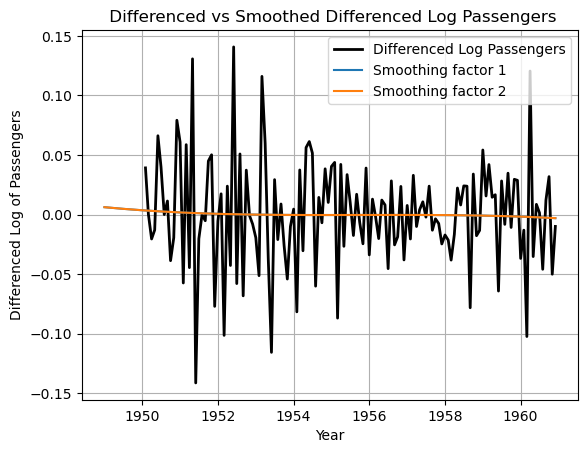

Augmented Dickey-Fuller test
                                  Value
ADF Test Statistic            -4.443325
p-value                        0.000249
Number of Lags Used           12.000000
Number of Observations Used  118.000000
Critical Value (1%)           -3.487022
Critical Value (5%)           -2.886363
Critical Value (10%)          -2.580009


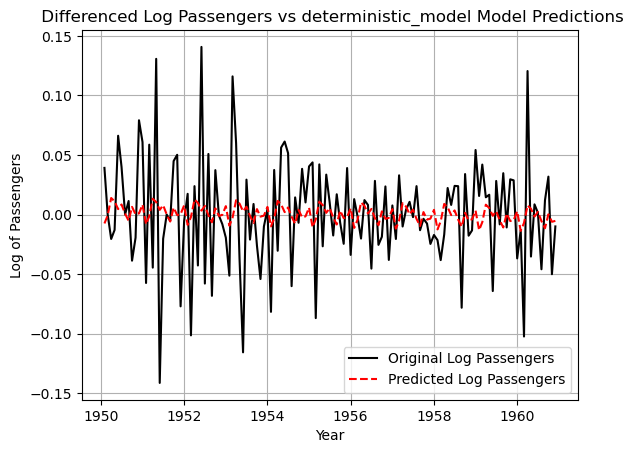

Ljung-Box test
      lb_stat  lb_pvalue
10  30.358652   0.000748


C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


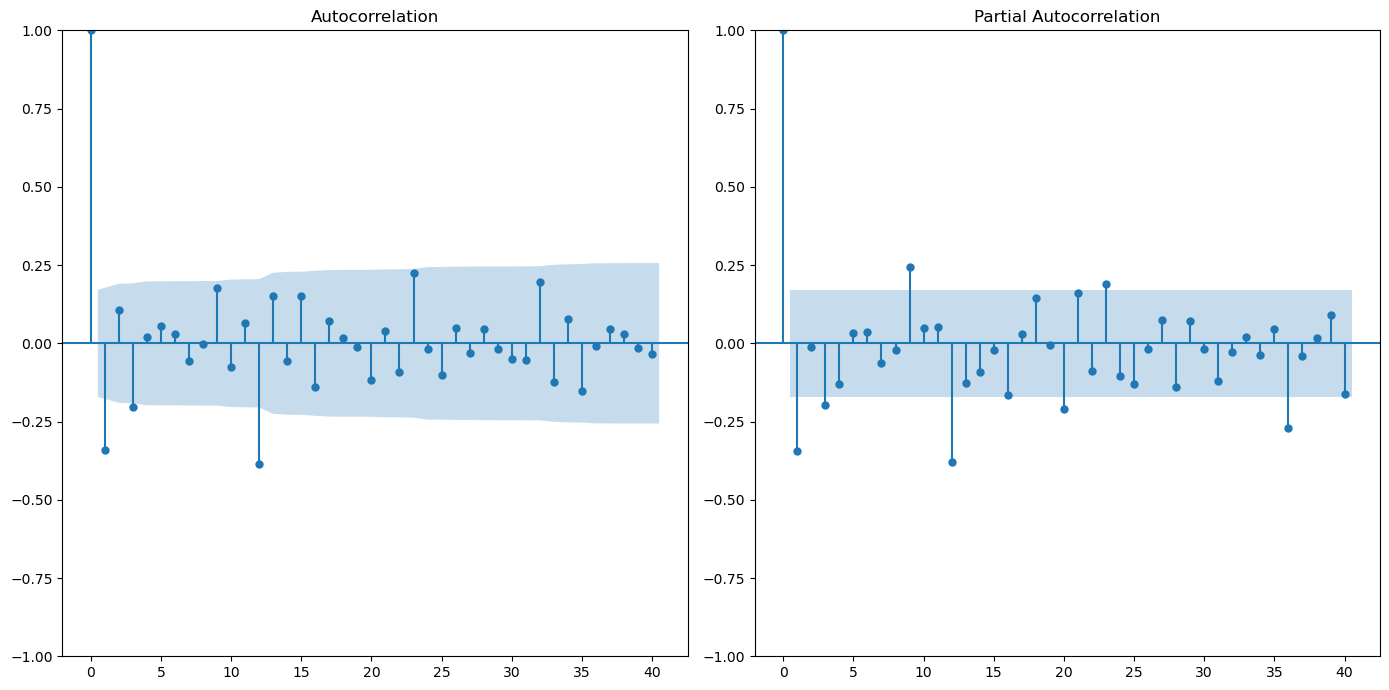

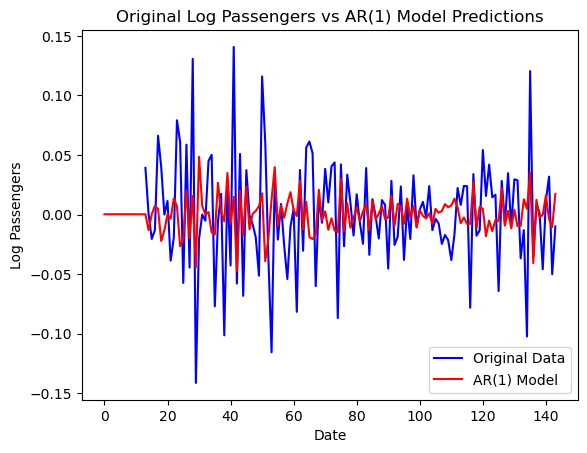

(      lb_stat  lb_pvalue
 10  14.222494   0.163083,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:     LogPassengers_diff   No. Observations:                  144
 Model:                 ARIMA(1, 0, 0)   Log Likelihood                 226.510
 Date:                Thu, 09 Nov 2023   AIC                           -447.020
 Time:                        16:27:20   BIC                           -438.111
 Sample:                             0   HQIC                          -443.400
                                 - 144                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.0002      0.003      0.084      0.933      -0.005       0.006
 ar.L1         -0

In [13]:
# 차분
data['LogPassengers_diff'] = data['Log_Passengers'].diff(12).diff().dropna()


# 차분 그림
smoothing_factors = [1, 2]

plt.plot(data['Month'], data['LogPassengers_diff'], label='Differenced Log Passengers', color='black', linewidth=2)
for s in smoothing_factors:
    spline = UnivariateSpline(data['Month'].map(pd.Timestamp.toordinal), data['LogPassengers_diff'].fillna(0), s=s)
    plt.plot(data['Month'], spline(data['Month'].map(pd.Timestamp.toordinal)), label=f'Smoothing factor {s}')

plt.xlabel('Year')
plt.ylabel('Differenced Log of Passengers')
plt.title(' Differenced vs Smoothed Differenced Log Passengers')
plt.legend()
plt.grid(True)
plt.show()

# 정상성 확인을 위한 Augmented Dickey-Fuller test 
print('Augmented Dickey-Fuller test' )
adf_test = adfuller(data['LogPassengers_diff'].dropna())

adf_results = pd.DataFrame({
    'ADF Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Number of Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Value (1%)': adf_test[4]['1%'],
    'Critical Value (5%)': adf_test[4]['5%'],
    'Critical Value (10%)': adf_test[4]['10%']
}, index=['Value']).transpose()

print(adf_results)

# deterministic model
data_diff = data.copy()
data_diff['DiffLogPassengers'] = data_diff['Log_Passengers'].diff(12).diff()
data_diff = data_diff.dropna()

data_diff['TimeIndex'] = range(1, len(data_diff) + 1)
data_diff['Month_Num'] = data_diff['Month'].dt.month
month_dummies = pd.get_dummies(data_diff['Month_Num'], prefix='Month', drop_first=True)

X_new = pd.concat([data_diff[['TimeIndex']], month_dummies], axis=1)
X_new = sm.add_constant(X_new)  # adding a constant
y = data_diff['DiffLogPassengers']

model_new = sm.OLS(y, X_new).fit()

model_summary_new = model_new.summary()
model_summary_new

data_diff['deterministic_model'] = model_new.predict(X_new)

plt.plot(data_diff['Month'], data_diff['DiffLogPassengers'], label='Original Log Passengers', color='black')
plt.plot(data_diff['Month'], data_diff['deterministic_model'], label='Predicted Log Passengers', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Log of Passengers')
plt.title(' Differenced Log Passengers vs deterministic_model Model Predictions')
plt.legend()
plt.grid(True)
plt.show()

residuals = model_new.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print('Ljung-Box test')
print(lb_test)

# acf, pacf
plt.figure(figsize=(14, 7))
plot_acf(data['LogPassengers_diff'].dropna(), lags=40, ax=plt.subplot(1, 2, 1))
plot_pacf(data['LogPassengers_diff'].dropna(), lags=40, ax=plt.subplot(1, 2, 2))

plt.tight_layout()
plt.show()

# stachastic model AR(1)
model_ar1 = ARIMA(data['LogPassengers_diff'], order=(1, 0, 0))
results_ar1 = model_ar1.fit()

ljung_box_results = acorr_ljungbox(results_ar1.resid.dropna(), lags=[10], return_df=True)

plt.plot(data['LogPassengers_diff'], label='Original Data', color='blue')
plt.plot(results_ar1.fittedvalues, label='AR(1) Model', color='red')
plt.title('Original Log Passengers vs AR(1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Log Passengers')
plt.legend()
plt.show()

ljung_box_results, results_ar1.summary()


# 12개월, 1개월을 동시에 차분 한 데이터로 ARMA

In [14]:

data['LogPassengers_diff'] = data['Log_Passengers'].diff(12).diff(1).dropna()

# p와 q의 범위를 지정.  여기서는 0부터 3까지 범위 지정
p = q = range(0, 3)
d = 0  # 이미 차분을 통해 데이터를 정상성을 만족시켰기 때문에 d는 0
pdq_combinations = list(itertools.product(p, [d], q))

# ARIMA 모델을 적합시키고 AIC 값을 저장할 리스트를 준비
models_aic_bic = []

# 각각의 p, d, q 조합에 대해 ARIMA 모델을 적합하고 AIC 및 BIC를 계산
for combination in pdq_combinations:
    try:
        # ARIMA 모델 적합
        model = ARIMA(data['LogPassengers_diff'], order=combination)
        model_fit = model.fit()
        # AIC 및 BIC 저장
        models_aic_bic.append((combination, model_fit.aic, model_fit.bic))
    except:
        continue

# AIC가 가장 낮은 모델
models_aic_bic.sort(key=lambda x: x[1])
best_model = models_aic_bic[0]

# 결과 출력
best_model_pdq = best_model[0]
best_model_aic = best_model[1]
best_model_bic = best_model[2]
best_model_pdq, best_model_aic, best_model_bic

C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


((2, 0, 1), -450.16530441825114, -435.3162379203711)

#  ARMA(2,1)이 AIC 기준 가장 좋은 모델 

C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\INHA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters fo

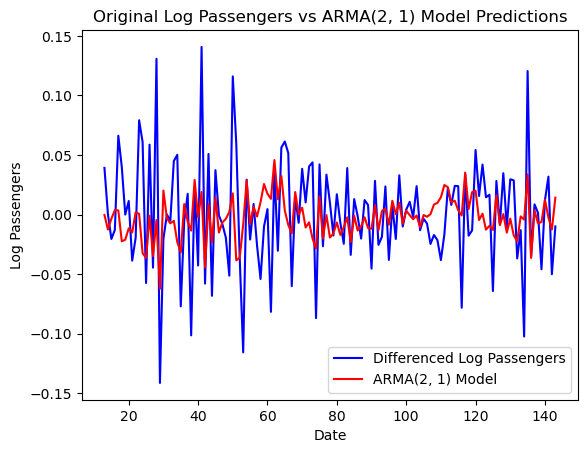

ljung_box test


(      lb_stat  lb_pvalue
 10  11.416867   0.325975,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:     LogPassengers_diff   No. Observations:                  131
 Model:                 ARIMA(2, 0, 1)   Log Likelihood                 230.046
 Date:                Thu, 09 Nov 2023   AIC                           -450.092
 Time:                        16:27:21   BIC                           -435.716
 Sample:                             0   HQIC                          -444.250
                                 - 131                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -0.0003      0.001     -0.585      0.559      -0.001       0.001
 ar.L1          0

In [15]:
# ARMA(2, 1) 구축
model_ar1 = ARIMA(data['LogPassengers_diff'].dropna(), order=(2, 0, 1))
results_ar1 = model_ar1.fit()

# Ljung-Box test
ljung_box_results = acorr_ljungbox(results_ar1.resid, lags=[10], return_df=True)

# 원데이터와 그림으로 비교
plt.plot(data['LogPassengers_diff'].dropna(), label='Differenced Log Passengers', color='blue')
plt.plot(results_ar1.fittedvalues, label='ARMA(2, 1) Model', color='red')
plt.title('Original Log Passengers vs ARMA(2, 1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Log Passengers')
plt.legend()
plt.show()

print('ljung_box test')
ljung_box_results, results_ar1.summary()